In [1]:
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import emoji

In [2]:
df = pd.read_csv(r"/Users/kiahvaidya/Desktop/toxic/combined_hate_speech_dataset.csv")

In [3]:
def clean_text(text):
    text = str(text).lower()
    text = emoji.replace_emoji(text, replace='')  # remove emojis
    text = re.sub(r'http\S+', '', text)           # remove URLs
    text = re.sub(r'@\w+', '', text)              # remove mentions
    text = re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', text)  # keep English + Hindi
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

In [4]:
df.head()

,text,hate_label,source,profanity_score,language,dataset_version,combined_date,text_length,word_count,clean_text
0,Knowing ki Vikas kitna samjhata hai Priyanka a...,0,hate_speech_tsv,0,hinglish,v1.0,2025-09-11,126,25,knowing ki vikas kitna samjhata hai priyanka a...
1,I am Muhajir .. Aur mere lye sab se Pehly Paki...,0,hate_speech_tsv,0,hinglish,v1.0,2025-09-11,196,41,i am muhajir aur mere lye sab se pehly pakista...
2,Doctor sab sahi me ke PhD (in hate politics) ...,0,hate_speech_tsv,0,hinglish,v1.0,2025-09-11,166,29,doctor sab sahi me ke phd in hate politics wal...
3,Poore Desh me Patel OBC me aate Hain sirf gujr...,0,hate_speech_tsv,0,hinglish,v1.0,2025-09-11,257,49,poore desh me patel obc me aate hain sirf gujr...
4,Sarkar banne ke bad Hindu hit me ek bhi faisla...,1,hate_speech_tsv,0,hinglish,v1.0,2025-09-11,140,25,sarkar banne ke bad hindu hit me ek bhi faisla...


In [5]:
X = df['text']
y = df['hate_label']

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# ---------------- TF-IDF VECTORIZATION ----------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF Shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

TF-IDF Shapes: (23640, 5000) (5910, 5000)


In [13]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_tfidf, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_bal))

Before SMOTE: [12660 10980]
After SMOTE: [12660 12660]


In [14]:
model = LogisticRegression(max_iter=300)
model.fit(X_train_bal, y_train_bal)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


In [15]:
y_pred = model.predict(X_test_tfidf)

In [16]:
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Not Offensive', 'Offensive']))


--- Classification Report ---
               precision    recall  f1-score   support

Not Offensive       0.73      0.70      0.71      3165
    Offensive       0.67      0.69      0.68      2745

     accuracy                           0.70      5910
    macro avg       0.70      0.70      0.70      5910
 weighted avg       0.70      0.70      0.70      5910



In [18]:
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.6981


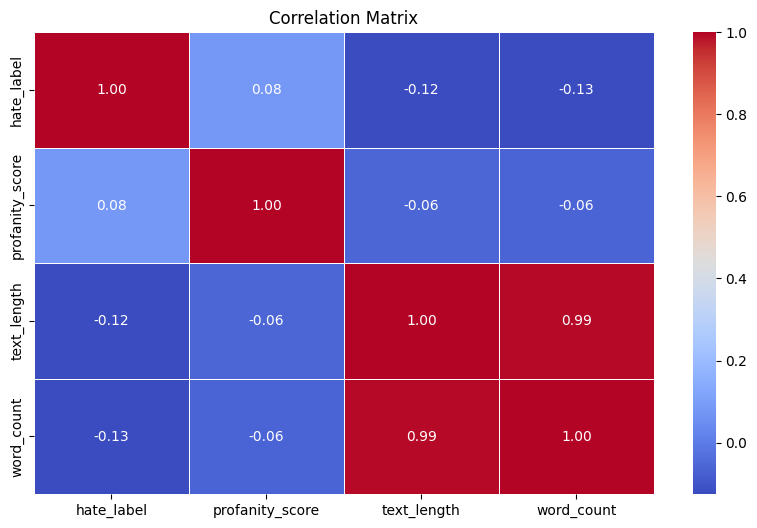

In [19]:
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [21]:
import joblib
joblib.dump(model, "models/model_offensive.pkl")

['models/model_offensive.pkl']

In [24]:
vectorizer = TfidfVectorizer(max_features=5000)

# ✅ Fit on training text (assuming X_train is your training text data)
X_train_tfidf = vectorizer.fit_transform(X_train)

# Save the fitted vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']